In [4]:
# arrays
import numpy as np

# unpacking files 
import tarfile

# fits
from astropy.io import fits
from astropy.utils.data import download_file

# plotting
import matplotlib.pyplot as plt
from matplotlib import ticker

# stella CNN functions
import stella

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D

# sklearn for performance metrics
from sklearn import metrics

# lightkurve
from lightkurve.search import search_lightcurve

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')

# set random seed for reproducibility 
np.random.seed(42)

# Exercise 1: better performance with a better model

We'll take the same steps as in the other notebook, but with less narrative in between.

In [5]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_stella_500.tar.gz'


file = tarfile.open(download_file(file_url, cache=True))


file.extractall('.')
file.close() # be sure to close files when you're finished with them!

data_dir = './hellouniverse_stella_500/'
ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+'Guenther_2020_flare_catalog.txt')

Reading in training set files.


100%|██████████| 62/62 [00:00<00:00, 469.93it/s]

502 positive classes (flare)
1342 negative classes (no flare)
37.0% class imbalance



In [6]:
# remove lightcurves with NaNs from training, test and validation data
def remove_nans(input_data):
    '''Determine indices of files without NaNs'''

    idx = []
    for k in range(np.shape(input_data)[0]):
        if len(input_data[k, :, :][np.isnan(input_data[k, :, :])]) == 0:
            idx.append(k)
    # AS: how do we want to talk about functions? assume that people know how they work for the intermediate notebooks?
    return idx


# find indices in train, test and validation sets without NaNs
idx_train = remove_nans(ds.train_data)
idx_test = remove_nans(ds.test_data)
idx_val = remove_nans(ds.val_data)

ds.train_data = ds.train_data[idx_train]
ds.train_labels = ds.train_labels[idx_train]

ds.test_data = ds.test_data[idx_test]
ds.test_labels = ds.test_labels[idx_test]

ds.val_data = ds.val_data[idx_val]
ds.val_labels = ds.val_labels[idx_val]

In [7]:
# set the random seed
seed = 42
np.random.seed(seed)

dense = 128

filter1 = 16
filter2 = 64

# ok, let's do a real hyperparameter optimization.

dense = 128

dropout = 0.1 # let's keep this low for now.

data_shape = np.shape(ds.train_data)
input_shape = (np.shape(ds.train_data)[1], 1)

# set up the network
x_in = Input(shape=input_shape)
c0 = Convolution1D(7, filter1, activation='relu', padding='same', input_shape=input_shape)(x_in)
b0 = MaxPooling1D(pool_size=2)(c0)
d0 = Dropout(dropout)(b0)

c1 = Convolution1D(3, filter2, activation='relu', padding='same')(d0)
b1 = MaxPooling1D(pool_size=2)(c1)
d1 = Dropout(dropout)(b1)


f = Flatten()(d1)
z0 = Dense(dense, activation='relu')(f)
d2 = Dropout(dropout)(z0)
y_out = Dense(1, activation='sigmoid')(d2)


# instantiate the network
cnn = Model(inputs=x_in, outputs=y_out)

# Compile Model
optimizer = 'adam'
fit_metrics = ['accuracy'] 
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)
cnn.summary()


nb_epoch = 500 # the model sees the dataset 100 times
batch_size = 64 # 64 light curves are seen before the model updates itself

# between each epoch, present the data in a different order. This can help prevent overfitting or order bias.
shuffle = True 

# Train
history = cnn.fit(ds.train_data, ds.train_labels,
                  batch_size=batch_size, 
                  epochs=nb_epoch, 
                  validation_data=(ds.val_data, ds.val_labels), 
                  shuffle=shuffle,
                  verbose=False) # we lower the verbosity — because that's a lot of epochs to priont!

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 200, 7)            119       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 7)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 7)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 3)            1347      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 3)            0         
 1D)                                                         

In [8]:
def plot_confusion_matrix(cnn, input_data, input_labels):
    
    # Compute flare predictions for the test dataset
    predictions = cnn.predict(input_data)

    # Convert to binary classification 
    predictions = (predictions > 0.5).astype('int32') 
    
    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1])
    cm = cm.astype('float')

    # Normalize the confusion matrix results. 
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm, cmap='binary_r')

    plt.title('Confusion matrix', y=1.08)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Flare', 'No Flare'])
    
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Flare', 'No Flare'])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt), 
                    ha="center", va="center",color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

6/6 [==============================] - 0s 3ms/step


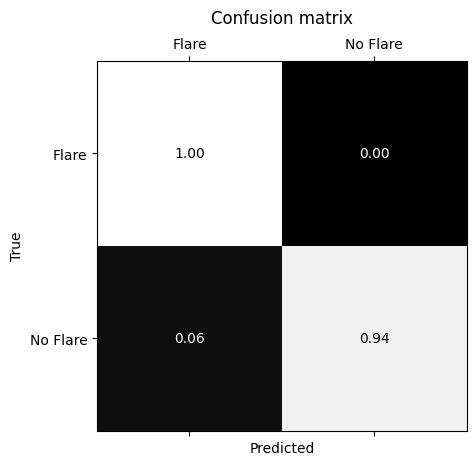

In [ ]:
plot_confusion_matrix(cnn, ds.test_data, ds.test_labels)


In [ ]:
# need to check the validation and loss

Text(0, 0.5, 'Loss')

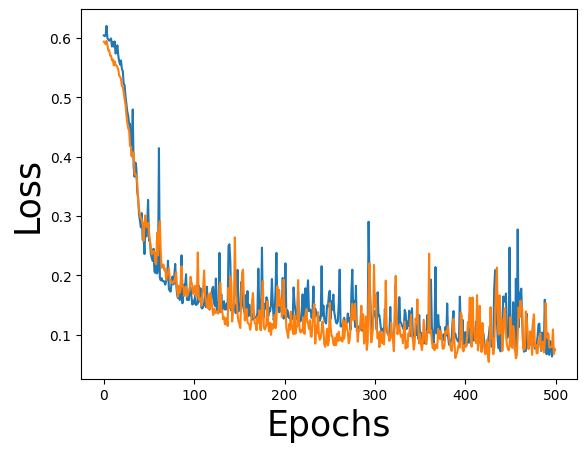

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Loss', fontsize=25)

Text(0, 0.5, 'Accuracy')

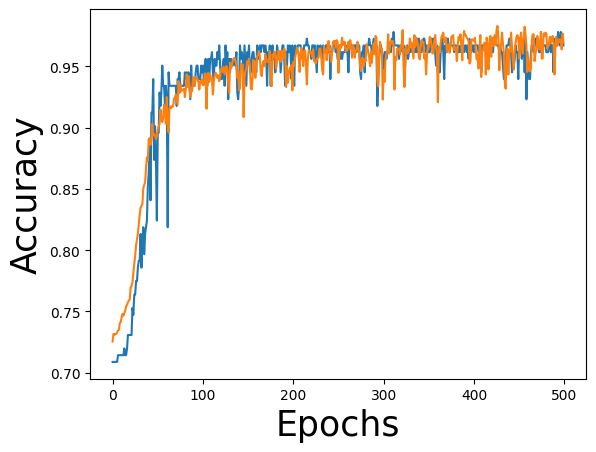

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)

It seems like the validation and training loss are beginning to plateau. However, we haven't entered a particularly nasty regime yet — i.e., the validation loss hasn't begun to *increase*. So, it seems like there's still some room for more training even with just this dataset.

# Exercise 2: better performance with more data

Do note that using *this much more data* can take quite some time to download.

In [ ]:
# take 2: more data. we'll use the download_catalog function from the stella documentation.
download = stella.DownloadSets(fn_dir='.')
download.download_catalog()
download.flare_table = download.flare_table[0:4000]
download.download_lightcurves()
ds = stella.FlareDataSet(downloadSet=download)

 25%|██▍       | 146/587 [18:26<11:25,  1.55s/it]  

In [ ]:
ds = stella.FlareDataSet(fn_dir='.',
                         catalog='./'+'Guenther_2020_flare_catalog.txt')

In [ ]:
# set the random seed
seed = 42
np.random.seed(seed)

dense = 128

filter1 = 16
filter2 = 64

# ok, let's do a real hyperparameter optimization.

dense = 128

dropout = 0.1 # let's keep this low for now.

data_shape = np.shape(ds.train_data)
input_shape = (np.shape(ds.train_data)[1], 1)

# set up the network
x_in = Input(shape=input_shape)
c0 = Convolution1D(7, filter1, activation='relu', padding='same', input_shape=input_shape)(x_in)
b0 = MaxPooling1D(pool_size=2)(c0)
d0 = Dropout(dropout)(b0)

c1 = Convolution1D(3, filter2, activation='relu', padding='same')(d0)
b1 = MaxPooling1D(pool_size=2)(c1)
d1 = Dropout(dropout)(b1)


f = Flatten()(d1)
z0 = Dense(dense, activation='relu')(f)
d2 = Dropout(dropout)(z0)
y_out = Dense(1, activation='sigmoid')(d2)


# instantiate the network
cnn = Model(inputs=x_in, outputs=y_out)

# Compile Model
optimizer = 'adam'
fit_metrics = ['accuracy'] 
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)
cnn.summary()


nb_epoch = 500 # the model sees the dataset 100 times
batch_size = 64 # 64 light curves are seen before the model updates itself

# between each epoch, present the data in a different order. This can help prevent overfitting or order bias.
shuffle = True 

# Train
history = cnn.fit(ds.train_data, ds.train_labels,
                  batch_size=batch_size, 
                  epochs=nb_epoch, 
                  validation_data=(ds.val_data, ds.val_labels), 
                  shuffle=shuffle,
                  verbose=False) # we lower the verbosity — because that's a lot of epochs to priont!

In [ ]:
plot_confusion_matrix(cnn, ds.test_data, ds.test_labels)


In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Loss', fontsize=25)

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)

# Exercise 3: Masking out data gaps

Below is an example function to mask out gaps in data.

In [ ]:
from lightkurve.search import search_lightcurve
import matplotlib.pyplot as plt
import numpy as np

In [1]:
conda run pip install git+https://github.com/afeinstein20/stella

  Cloning https://github.com/afeinstein20/stella to /tmp/pip-req-build-h0qpg4f4
  Resolved https://github.com/afeinstein20/stella to commit f9ffd78d1c7279012e870f3657812595f18eee74
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'

  Running command git clone --filter=blob:none --quiet https://github.com/afeinstein20/stella /tmp/pip-req-build-h0qpg4f4


Note: you may need to restart the kernel to use updated packages.


In [2]:
import stella

2023-07-19 13:56:20.148228: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 13:56:20.200330: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 13:56:20.201132: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 13:56:21.086325: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [43]:
def data_mask(time, predictions):
    """
    approach: if there's a gap of more than 10x the median difference in timestamps.
    
    Inputs
    ------
        :time: lightkurve-output timestamps. (array-like)
        :predictions: stella-output flare predictions. Same size as :time: (array-like)
        
    Outputs
    -------
        :time: lightkurve-output timestamps. (array-like)
        :predictions: stella-output flare predictions, now with data gaps set to 0. Same size as :time: (array-like)
        
    """
    
    # mask the beginning and end. They're effectively "gaps" of data on the end.
    predictions[:100] = 0.
    predictions[-100:] = 0.
    
    median_diff = np.median(np.diff(time))
    
    gap_diff = 10 * median_diff
    
    gap_inds = np.argwhere(np.diff(lc.time.value) > gap_diff.value).flatten()
    
    # now we want to pad the gap indices by 100 time stamps on either side.
    mask_starts = gap_inds - 100
    mask_ends = gap_inds + 100
    
    # iterate through the mask starts and ends and set the predictions in this region to 0.
    for mask_start, mask_ends in zip(mask_starts, mask_ends):
        predictions[mask_start:mask_ends] = 0.
        
    return time, predictions 
    
    

In [44]:
# gather a list of TIC (Tess Input Catalog) identification numbers.

ticids = ['120461526', '278779899', '139754153', '273418879', '52121469', '188580272', '394015919', '402104884']


# for all the selected targets, pull the available lightcurves using the lightkurve package
sectors = [1, 2] # only consider the first few sectors
lcs = []
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()
    lcs.append(lc)

In [45]:
# load the CNN using `stella`
data_dir = './hellouniverse_stella_500/'
cnn_file = 'initial_flare_model_small_dataset.h5'
ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+'Guenther_2020_flare_catalog.txt')
cnn_stella = stella.ConvNN(output_dir=data_dir, ds=ds)

Reading in training set files.


100%|██████████| 62/62 [00:00<00:00, 399.94it/s]

502 positive classes (flare)
1342 negative classes (no flare)
37.0% class imbalance



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


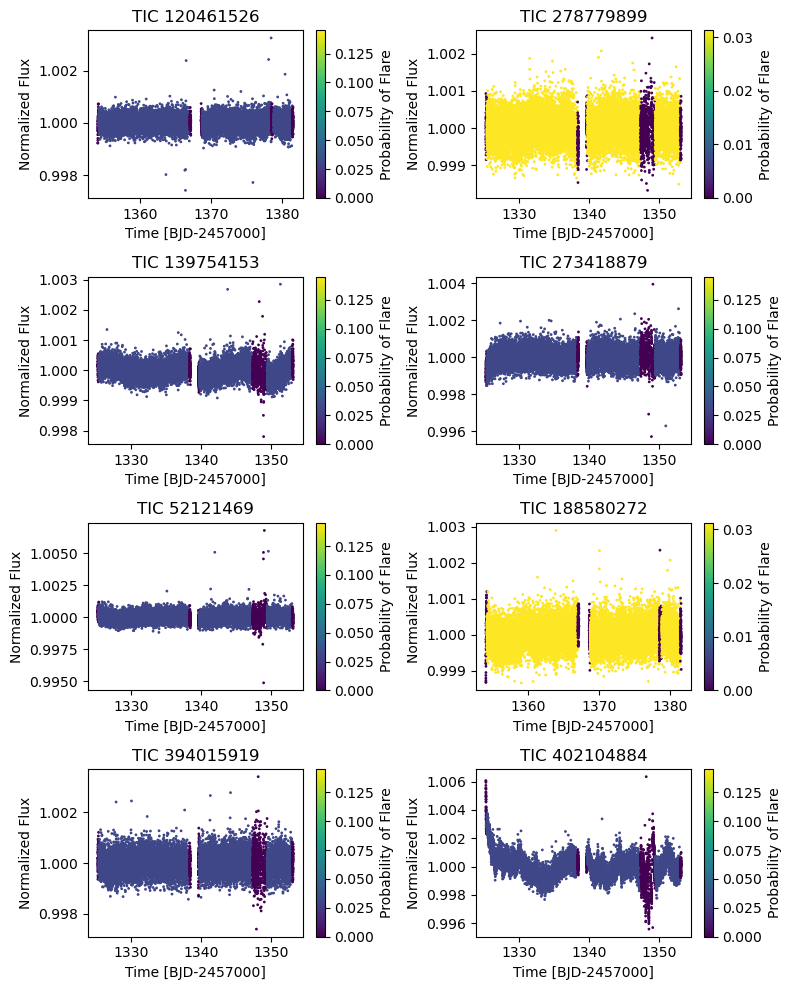

In [46]:
fig = plt.figure(0, [8, 10])

for i, lc in enumerate(lcs):
    
    # pull out on the first light curve in each set, if more than one exist
    if len(lc)>0: lc = lc[0]
        
    # predict the flare probability light cuvey for the input data using `stella` 
    # (which applies the necessary pre-processing to the data for input to the CNN)
    
    cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
    time, predictions_masked = data_mask(lc.time, cnn_stella.predictions[0])
    
    ax = fig.add_subplot(4,2,i+1)
    im = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=predictions_masked, s=1. )
    
    plt.colorbar(im, ax=ax, label='Probability of Flare')
    ax.set_xlabel('Time [BJD-2457000]')
    ax.set_ylabel('Normalized Flux')
    ax.set_title('TIC {}'.format(lc.targetid));
plt.tight_layout()
plt.show()

All the flares are gone! This motivates searching through more light curves.

# Exercise 4: Why CNNs?

Flares all share a common physical origin. Therefore, we expect flares to have a distinct evolution — that is, they should have a specific shape in the light curve. CNNs can incorporate information from neighboring time stamps in a light curve, so they can capture multiple points of a flare to classify it. In principle, this means that it can "learn" the shape of a flare using multiple adjacent data points at once.